# 3-4. 深層学習の基礎と展望 - 畳み込みニューラルネットワーク（CNN）

[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上のサービスを利用して取得したデータを用いて，簡単な予測を行う畳み込みニューラルネットワークのサンプルコードを見ていこう．



## データの取得・整形
今回は，データベース上からマンガ雑誌を取得し，週刊少年ジャンプの価格遷移を予想するモデルを作っていく．
以下のコードを[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)上に入力して実行する，または入力を省略した[こちらのURL](https://mediag.bunka.go.jp/madb_lab/lod/sparql/#query=PREFIX%20rdfs%3A%20%20%20%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX%20schema%3A%20%3Chttps%3A%2F%2Fschema.org%2F%3E%20SELECT%20%3F%E3%83%A9%E3%83%99%E3%83%AB%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5%20%3F%E4%BE%A1%E6%A0%BC%20%3F%E3%83%9A%E3%83%BC%E3%82%B8%0AWHERE%20%7B%0A%20%20%3F%E3%82%A2%E3%82%A4%E3%83%86%E3%83%A0%0A%20%20%20%20%20%20%20%20schema%3Agenre%20%22%E3%83%9E%E3%83%B3%E3%82%AC%E9%9B%91%E8%AA%8C%E5%8D%98%E5%8F%B7%22%3B%0A%20%20%20%20%20%20%20%20schema%3Aname%20%22%E9%80%B1%E5%88%8A%E5%B0%91%E5%B9%B4%E3%82%B8%E3%83%A3%E3%83%B3%E3%83%97%22%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3F%E3%83%A9%E3%83%99%E3%83%AB%3B%0A%20%20%20%20%20%20%20%20schema%3Aprice%20%3F%E4%BE%A1%E6%A0%BC%3B%0A%20%20%20%20%20%20%20%20schema%3AnumberOfPages%20%3F%E3%83%9A%E3%83%BC%E3%82%B8%3B%0A%20%20%20%20%20%20%20%20schema%3AdatePublished%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5.%0A%7D&endpoint=https%3A%2F%2Fmediag.bunka.go.jp%2Fsparql&requestMethod=POST&tabTitle=Query&headers=%7B%7D&contentTypeConstruct=application%2Fn-triples%2C*%2F*%3Bq%3D0.9&contentTypeSelect=application%2Fsparql-results%2Bjson%2C*%2F*%3Bq%3D0.9&outputFormat=table)から実行してデータを取得できる．

取得したCSVファイルを「週刊少年ジャンプ.csv」として保存し，このノートブック上にアップロードしよう．

※3-4. 再帰型ニューラルネットワーク（RNN）と同じデータセットを作成するため，もし同じものを持っている場合は以下の取得作業は不要なので，そちらをアップロードしよう．

```
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/> SELECT ?ラベル ?公開年月日 ?価格 ?ページ
WHERE {
  ?アイテム
        schema:genre "マンガ雑誌単号";
        schema:name "週刊少年ジャンプ";
        rdfs:label ?ラベル;
        schema:price ?価格;
        schema:numberOfPages ?ページ;
        schema:datePublished ?公開年月日.
}
```


In [ ]:
# 必要なモジュールの読み込み
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt

In [ ]:
jumps = pd.read_csv("/content/週刊少年ジャンプ.csv")
jumps = jumps.drop_duplicates().reset_index(drop=True)
jumps['公開年月日'] = pd.to_datetime(jumps['公開年月日'])
jumps.sort_values(by = '公開年月日', ascending = True, inplace = True)
jumps.reset_index(inplace=True, drop=True)

for i in jumps.index:
  price = re.sub(r"\D", "", jumps["価格"][i])
  if price != "":
    jumps["価格"][i] = int(price)
  else:
    jumps["価格"][i] = None

jumps = jumps.dropna()
jumps.reset_index(inplace=True, drop=True)
jumps

<ipython-input-2-ab251b28bf1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jumps["価格"][i] = int(price)
<ipython-input-2-ab251b28bf1f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jumps["価格"][i] = None


ラベル      公開年月日   価格   ページ
0     週刊少年ジャンプ 1969年 表示号数20 1969-11-03   90   296
1     週刊少年ジャンプ 1969年 表示号数21 1969-11-10   90   294
2     週刊少年ジャンプ 1969年 表示号数22 1969-11-17   90   312
3     週刊少年ジャンプ 1969年 表示号数23 1969-11-24   90   294
4     週刊少年ジャンプ 1969年 表示号数24 1969-12-01   90   294
...                     ...        ...  ...   ...
2379  週刊少年ジャンプ 2018年 表示号数24 2018-05-28  270  464p
2380  週刊少年ジャンプ 2018年 表示号数25 2018-06-04  270  496p
2381  週刊少年ジャンプ 2018年 表示号数26 2018-06-11  270  450p
2382  週刊少年ジャンプ 2018年 表示号数27 2018-06-18  270  492p
2383  週刊少年ジャンプ 2018年 表示号数28 2018-06-25  270  494p

[2384 rows x 4 columns]

得られた価格の推移を見てみよう．

(-365.0, 17897.0)

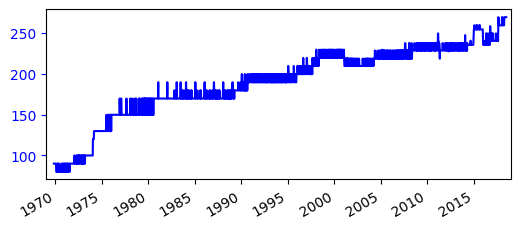

In [ ]:
span = pd.to_datetime(["1969-01-01", "2019-01-01"])

fig, ax = plt.subplots(figsize=(6, 2.5))
fig.autofmt_xdate()

ax.plot(jumps["公開年月日"], jumps["価格"], color='b')
ax.tick_params('y', colors='b')

ax.set_xlim(span)

かなり周期の小さい変動（振動）に加えて，全体的には増加の傾向の変動が見られることがわかる．

この二つの変動の種類が混ざっていると予測が難しそうなので，簡易化のために年価格平均のグラフを考えることで，全体的な増加の傾向を読み取りやすいグラフにしよう．

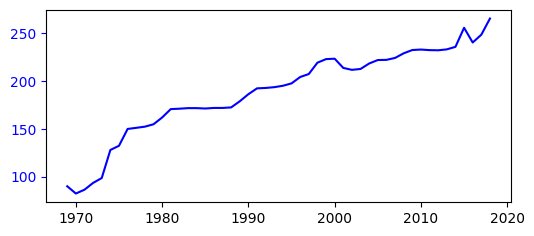

In [ ]:
years = []
price_means = []
for year in range(1969,2019):
  data = jumps[(jumps['公開年月日'] >= dt.datetime(year,1,1)) & (jumps['公開年月日'] < dt.datetime(year+1,1,1))]["価格"]
  price_mean = sum(data)/len(data.index)
  years.append(year)
  price_means.append(price_mean)

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(years, price_means, color='b')
ax.tick_params('y', colors='b')

価格平均の推移を見てみると，発売当初や最近のものについては変動が大きく予測が難しそうなので，今回はすべてのデータではなく，1985年〜2015年までの30年間のデータを利用することとする．

In [ ]:
#必要なモジュールの読み込み
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Reshape, Activation
from tensorflow.keras.optimizers import Adam

(41, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 16)            144       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 8)              1032      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 8)              0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 1)              65        
                                                                 
 activation (Activation)     (None, 4, 1)       

<ipython-input-6-fd04c636971f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_1975_2015["価格平均"] = pd.Series([(price - min_price)/price_width for price in price_1975_2015["価格平均"]]) # 全部で41件のデータがある


_________________________________________________________________
None
Epoch 1/100
9/9 [==============================] - 1s 22ms/step - loss: 0.5872 - val_loss: 0.6211
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.5421 - val_loss: 0.5525
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.4643 - val_loss: 0.4295
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3454 - val_loss: 0.2519
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2354 - val_loss: 0.2321
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2025 - val_loss: 0.1645
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1595 - val_loss: 0.1103
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1220 - val_loss: 0.0758
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0926 - val_loss: 0.0929
Epoch 10/100
9/9 [==============================] - 0s 

<Figure size 640x480 with 0 Axes>

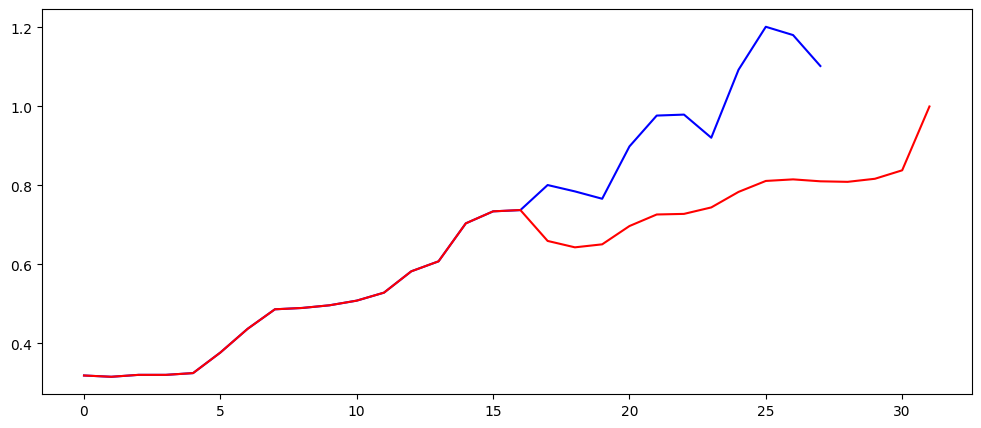

In [ ]:
price = pd.DataFrame(price_means, index=years, columns=["価格平均"])

# 1975-2015までのデータに絞る
price_1975_2015 = price[(price.index >=1975) & (price.index <= 2015)]
price_1975_2015.reset_index(inplace=True, drop=True)

# 1975-2015までの価格データを，0~1の間に入るように正規化
min_price = min(price_1975_2015["価格平均"])
price_width = max(price_1975_2015["価格平均"]) - min_price
price_1975_2015["価格平均"] = pd.Series([(price - min_price)/price_width for price in price_1975_2015["価格平均"]]) # 全部で41件のデータがある

#次の価格を予測するために，過去16件分の推移をみて4件分の予測をすることを考える
num_for_predict = 16
num_to_predict = 4

# Xは，1要素に連続16件分の価格が入ったリストになる
X = []
# yは，y[i]には，X[i]の16件の価格推移の後の4件分の価格が入ったリストになる
y = []


for i in range(len(price_1975_2015.index)-num_for_predict-num_to_predict+1):
  X.append(list(price_1975_2015["価格平均"][i : i+num_for_predict]))
  y.append(price_1975_2015["価格平均"][i+num_for_predict : i+num_for_predict+num_to_predict])

X = np.array(X) # (データ数, 16)
y = np.array(y) # (データ数，4)


# 3回*4個＝直近16個のデータをテストデータ用に残しておく
num_test = 3
X_train_cnn = np.array(X[:-num_test*num_to_predict])
y_train_cnn = np.array(y[:-num_test*num_to_predict])
X_test_cnn = np.array(X[-num_test*num_to_predict:])
y_test_cnn = np.array(y[-num_test*num_to_predict:])


print(price_1975_2015.shape)

# 入力Xと正解データyの準備
# 入力を(サンプル数、学習に使うデータの数（16）、データの説明変数の数（今回は価格のみの1次元）)の形にreshapeする
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
y_train_cnn = y_train_cnn.reshape((y_train_cnn.shape[0], y_train_cnn.shape[1], 1))

X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))
y_test_cnn = y_test_cnn.reshape((y_test_cnn.shape[0], y_test_cnn.shape[1], 1))

# モデルの構築
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=16, kernel_size=8, padding='same', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1))) # カーネルサイズ8のフィルターが16枚用意される．
model_cnn.add(MaxPooling1D(pool_size=2)) # 上の16個のフィルタによってそれぞれ作成された16の特徴量について，2個ずつMaxPooling(デフォルトでstride幅=poolsize)
model_cnn.add(Conv1D(filters=8, kernel_size=8, padding='same', activation='relu', strides=1))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=1, kernel_size=8, padding='same', activation='relu', strides=1))
model_cnn.add(Activation('linear'))

# モデルのコンパイル
model_cnn.compile(loss='mean_absolute_error', optimizer="adam")

print(model_cnn.summary())

# モデルの学習
model_cnn.fit(X_train_cnn, y_train_cnn, validation_split=0.05, epochs=100, batch_size=1)

# モデルの評価
model_cnn.evaluate(X_test_cnn, y_test_cnn)

test_cnn = X_train_cnn[-1].reshape(1, num_for_predict, 1) #　shape: (batch, num_for_predict, input_shape)

# 予測値を使ってさらに予測...を繰り返す
for i in range(num_test):
  input = test_cnn[:, -num_for_predict:, :]
  test_cnn = np.concatenate([test_cnn, model_cnn.predict(input)], axis=1) # 最後から{num_for_predict}個の要素を使って予測した値を末尾に追加

y_pred = test_cnn[num_for_predict:]
plt.clf()
fig_cnn, ax_cnn = plt.subplots(figsize=(12, 5))

# 予測値を青，実際の値を赤でプロット
# 前半は予測のために用いる実測値なので，後半のみが変わる
ax_cnn.plot(test_cnn.reshape(-1), color='b')
ax_cnn.plot(list(price_1975_2015["価格平均"][-((num_test+1)*num_to_predict+num_for_predict):]), color='r')

グラフを見比べることで，増加の傾向を学習できていることがわかる．